# Preprocessing for Nitrogen Loading Model (Nload)

## Objectives

Reclassify land use to including cranberry agriculture within subwatersheds of the Agawam (Wareham) and Coonamessett drainage basins. Generate a table of land use areas sorted into the following categories. 

Class Number|	Class Name
---|---
2|	Impervious
5|	Developed Open Space
6|	Cultivated Land
7|	Pasture/Hay
8|	Grassland
9|	Deciduous Forest
10|	Evergreen Forest
12|	Scrub/Shrub
13|	Palustrine Forested Wetland (C-CAP)
14|	Palustrine Scrub/Shrub Wetland (C-CAP)
15|	Palustrine Emergent Wetland (C-CAP)
16|	Estuarine Forested Wetland (C-CAP)
17|	Estuarine Scrub/Shrub Wetland (C-CAP)
18|	Estuarine Emergent Wetland (C-CAP)
19|	Unconsolidated Shore
20|	Bare Land
21|	Open Water
22|	Palustrine Aquatic Bed (C-CAP)
23|	Estuarine Aquatic Bed (C-CAP)


USEGENCODE|	USEGENNAME
---|---
0|	Unknown
2|	Open land
3|	Commercial
4|	Industrial
6|	Forest
7|	Agriculture
8|	Recreation
9|	Tax exempt
10| Mixed use, primarily residential
11|	Residential - single family
12|	Residential - multi-family
13|	Residential - other
20|	Mixed use, other
30|	Mixed use, primarily commercial
55|	Right-of-way
88|	Water


## References 
Kennedy, C. D., & Hoekstra, B. R. (2021). Measuring and modeling nitrogen export from cranberry farms. Ecosphere, 12(12), 1–15. https://doi.org/10.1002/ecs2.3686

Valiela, I., Geist, M., McClelland, J., & Tomasky, G. (2000). Nitrogen loading from watersheds to estuaries: Verification of the Waquoit Bay Nitrogen Loading Model. Biogeochemistry, 49(3), 277–293. https://doi.org/10.1023/A:1006345024374

Valiela, I., Collins, G., Kremer, J., Lajtha, K., Geist, M., Seely, B., … Sham, C. H. (1997). Nitrogen loading from coastal watersheds to receiving estuaries: New method and application. Ecological Applications, 7(2), 358–380. https://doi.org/10.1890/1051-0761(1997)007[0358:NLFCWT]2.0.CO;2


## Set up environment

In [14]:
# Load dependancies ***************************************
import arcpy as ap
import os, glob, re, sys
#import pandas as pd
#import numpy as np
#import scipy.stats

# Set up arcpy environment ******************************
# input data directory
idr = "C:\\Workspace\\Geodata\\Massachusetts\\"
# working directory this should be where arcgis project is located
wdr = "C:\\Workspace\\Geodata\\Nload\\"
# output directory
odr = os.path.join(wdr,'outputs')
# arcpy settings
ap.env.workspace = wdr # set arcpy environment working directory
aprx = arcpy.mp.ArcGISProject("Current") # current project
ap.CheckOutExtension("Spatial") # check out spatial extension
ap.env.outputCoordinateSystem = arcpy.SpatialReference("NAD 1983 UTM Zone 19N") # define cordinate system
# Allow overwriting of output
arcpy.env.overwriteOutput = True
#ap.SetProgressor("step", "processing...", step_value = 5)

Tip: see this [page](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/setprogressor.htm) for tips on arcpy settings. 

Tip: Use `os.path.join` to safely concatenate file paths. To do this enter folder names in quotes separated by commas.

Tip: Test in the geoprocessing tab first, then, once working, can copy python code from the geoprocessing tab when you click on the arrow next to `run`!  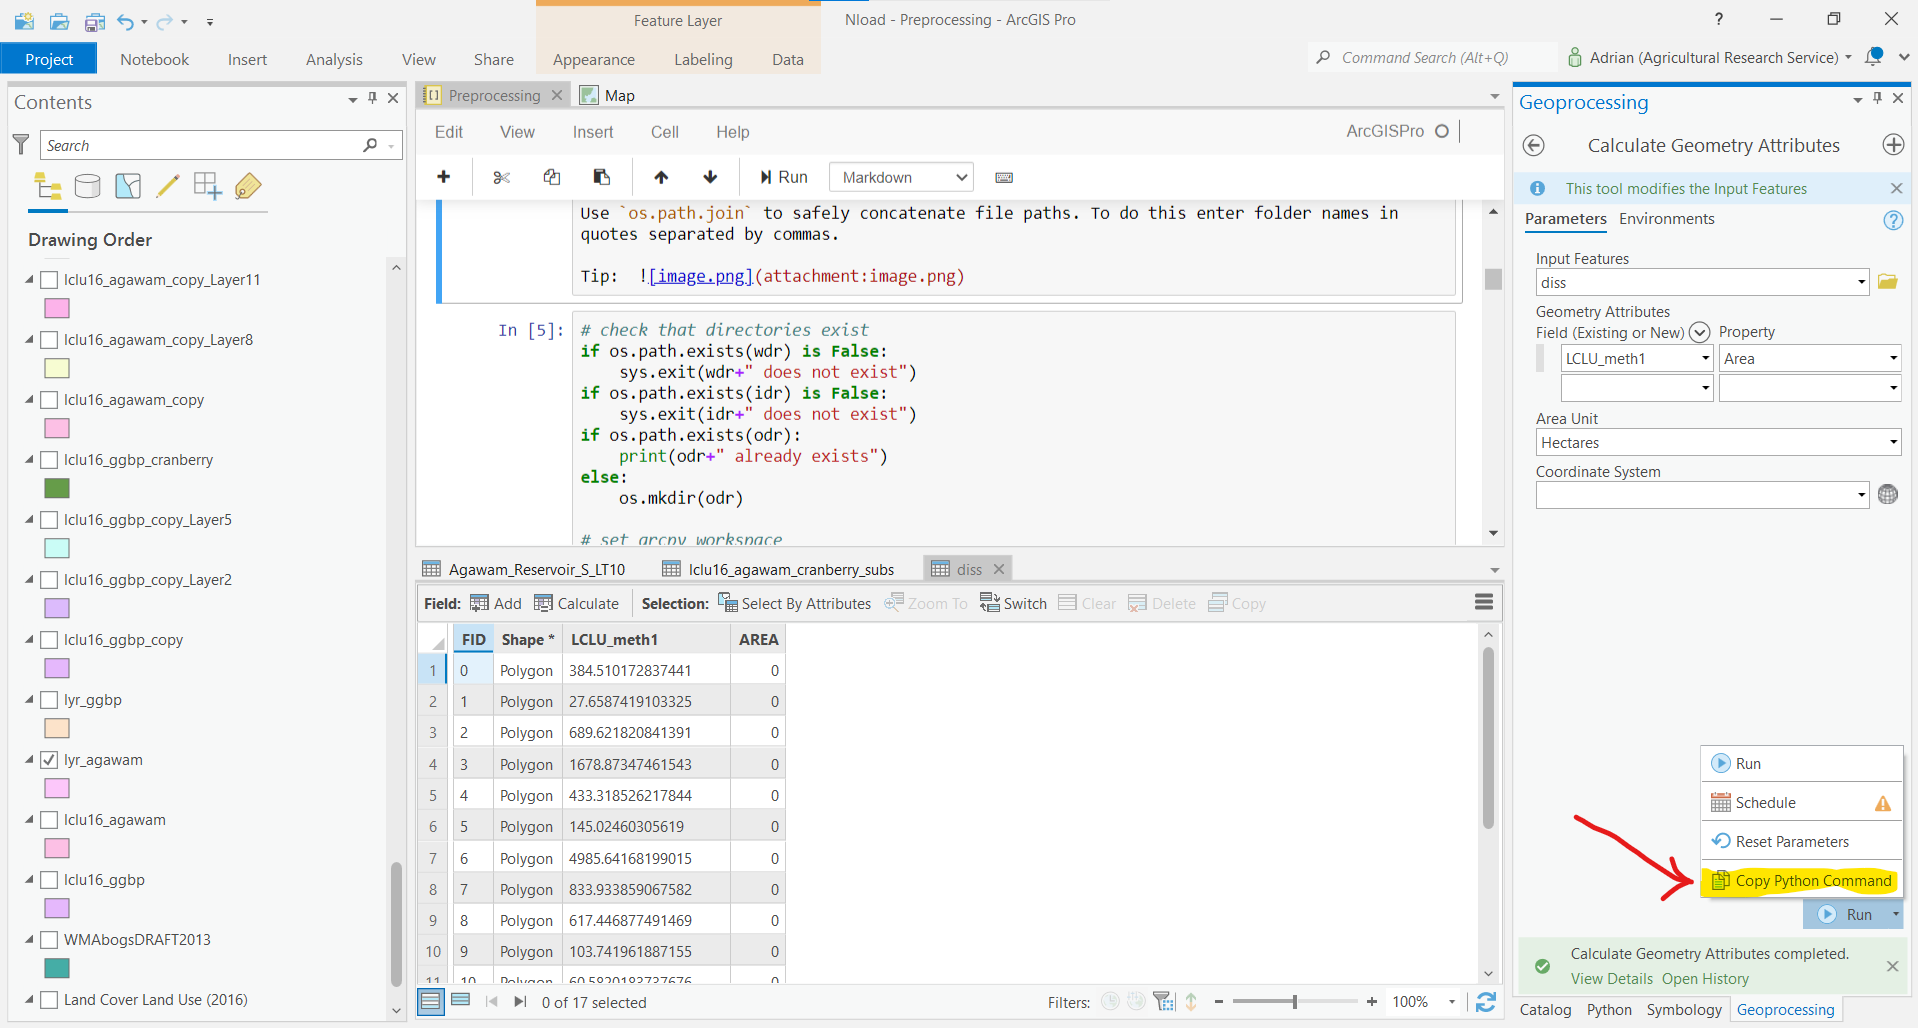

In [15]:
# check that directories exist
if os.path.exists(wdr) is False:
    sys.exit(wdr+" does not exist")
if os.path.exists(idr) is False:
    sys.exit(idr+" does not exist")
if os.path.exists(odr):
    print(odr+" already exists")
else:
    os.mkdir(odr)

C:\Workspace\Geodata\Nload\outputs already exists


Tip: Use `arcpy.FeatureSet` to add an input feature as an object to the current environment. Alternatively, `arcpy.management.MakeFeatureLayer` can be used to add input feature as a layer to the current project. The added layer should appear on the map. `arcpy.Copyfeatures_management` works in a similar way to `MakeFeatureLayer`. 

## Load input files

In [16]:
# Add Input Data *********************************** 
# Massachusetts 2016 Land Use Land Cover Layer 
path = os.path.join(idr,"lclu_gdb","MA_LCLU2016.gdb","LANDCOVER_LANDUSE_POLY")
MA_LCLU2016 = ap.FeatureSet(path)
#ap.management.MakeFeatureLayer(path, "lyr_lclu16")

In [25]:
# Massachusetts cranberry agriculture (source: Jim McLaughlin)
# this needs to be updated
path = os.path.join(idr,'WMAbogsDRAFT2013\\WMAbogsDRAFT2013.shp')
os.path.exists(path)
arcpy.CopyFeatures_management(path, "WMAbogsDRAFT2013")
bogs = ap.FeatureSet(path)
#ap.management.MakeFeatureLayer(path, "lyr_ggbp")
path = os.path.join(idr,'Wareham_Bogs_v3\\WarehamBogs_master_v3.shp')
os.path.exists(path)
arcpy.CopyFeatures_management(path, "Wareham_Bogs_master_v3")
wareham_bogs = ap.FeatureSet(path)

In [18]:
# Subcatchments of Agawam (Wareham) 
path = os.path.join(idr,"agawam_WS","agawam_subw_0309.shp")
agawam = ap.FeatureSet(path)
ap.management.MakeFeatureLayer(path, "lyr_agawam")

# Subcatchments of Great, Green, and Bourne Ponds
path = os.path.join(idr,"GGBsheds","Great_Green_Bourne_Ponds.shp")
os.path.exists(path)
#arcpy.CopyFeatures_management(path, "lyr_ggbp_a")
ggbp = ap.FeatureSet(path)
ap.management.MakeFeatureLayer(path, "lyr_ggbp")

<Result 'lyr_ggbp'>

Note: We may need to update cranberry bog outlines with recent renovations. The code below can be used as a template for downloading imagery from mass gis portal.

## Main program

`analysis.Clip` clips the first input with the boundary of the second input and adds the output to the map as a layer. The output is also saved to the arcpy environment working directory, or the specified file path. Note I have used different ways to reference the arguments below. 


Default geodatabase in the environment workspace
>`ap.analysis.Clip(MA_LCLU2016, agawam,"LCLU16_agawam")`

Specified file path
>`ap.analysis.Clip('lyr_lclu16', 'lyr_ggbp',os.path.join(odr,"LCLU16_ggbp"))`

In [19]:
# Clip Statewide Landuse Layer to Watershed Boundary
infeat = MA_LCLU2016
clipfeats = ["lyr_ggbp","lyr_agawam"]

for clipfeat in clipfeats:
    outname = "lclu16_" + clipfeat.split("lyr_")[1]
    outpath = os.path.join(odr,outname)
    ap.analysis.Clip(infeat,clipfeat,outpath)
    print("success, file saved to path:\n")
    print(outpath)

success, file saved to path:

C:\Workspace\Geodata\Nload\outputs\lclu16_ggbp
success, file saved to path:

C:\Workspace\Geodata\Nload\outputs\lclu16_agawam


The next step is to create a new land use layer that includes cranberry bogs. Cranberry bogs are classified as cultivated areas in the landuse layer. The trick here is to use only the perimeter of the cranberry bogs. There are two approaches to do this. 

1. Use the 2016 landuse layers recode cultivated areas that overlap cranberry bogs to a code for cranberry bogs. 

2. Clip out areas that overlap with cranberry bogs. Then Join the cranberry bog layer with the land use layer. 

In [20]:
# Select features that overlap with bog perimiters
#infile = ap.management.CopyFeatures(MA_LCLU2016,os.path.join(odr,"MA_LULC2016_cranberry"))

<FeatureSet object at 0x1a38a581b88[0x1a38a467fd0]>

In [21]:
def fnReclassifyCranberryMethod1 (LUC_layername,cranberry_layer):
    '''
    infile is the landcover dataset 
    '''
    copyfilename = LUC_layername+"_copy"
    outfilename = LUC_layername+"_cranberry"
    copy_path = os.path.join(odr,copyfilename)
    out_path = os.path.join(odr,outfilename)
    relatefile = cranberry_layer
    relationship = "CROSSED_BY_THE_OUTLINE_OF"
    newfield = "LCLU_meth1"
    
    copy = ap.management.CopyFeatures(LUC_layername,copy_path)
    
    ap.management.CalculateField(copy,
                                field = newfield,
                                expression = "!COVERNAME!",
                                expression_type="PYTHON3"
                                )

    select = arcpy.SelectLayerByLocation_management(copy,relationship,relatefile)

    # The code block must not have extra indents
    codeblock = """
def mydef(luc):
    if luc == "Cultivated":
        return luc+"_Cranberry"
    else:
        return luc
"""

    #ap.AddField_management(outfile,"covername1")
    ap.management.CalculateField(select,
                                field = newfield,
                                expression = "mydef(!COVERNAME!)",
                                expression_type="PYTHON3",
                                code_block = codeblock
                                )
    #ap.management.CopyFeatures(select,LUC_path)
    ap.SelectLayerByAttribute_management(copy, "CLEAR_SELECTION")
    ap.management.CopyFeatures(copy,out_path)
    return

'''
LUC_layername = "lclu16_agawam"
cranberry_layer = bogs

fnReclassifyCranberryMethod1(LUC_layername,cranberry_layer)
'''

'\nLUC_layername = "lclu16_agawam"\ncranberry_layer = bogs\n\nfnReclassifyCranberryMethod1(LUC_layername,cranberry_layer)\n'

In [24]:
LUC_layernames = ["lclu16_ggbp","lclu16_agawam"]
cranberry_layer = bogs
for LUC_layername in LUC_layernames:
    fnReclassifyCranberryMethod1(LUC_layername,cranberry_layer)

Next step is to calculate area of each land use type within each subcatchment.

This can be done through arcgis functions or converting the attribute table to a [pandas `DataFrame`](https://developers.arcgis.com/python/guide/part3-introduction-to-pandas/) and then working with python packages. 

For the `arcpy` workflow, first dissolve the land use layer by the land use type. This will make one feature for each land use type. Then use [spatial join](https://pro.arcgis.com/en/pro-app/latest/tool-reference/analysis/spatial-join.htm) to   divide the dissolved land use layer into each subcatchment. 



https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/dissolve.htm

All of the above code works and doesn't need to be rerun. Resume here. The code above is not working properly, consider using split. 

In [13]:
catchments = ["agawam","ggbp"]
for catchment in catchments:
    LUCname = 'lclu16_'+catchment+'_cranberry'
    catchname = 'lyr_'+catchment
    outtable = catchment+"_lclu16_Summary"
    arcpy.analysis.SummarizeWithin(
        catchname, 
        LUCname, 
        catchment+"_SummarizeWithin", 
        "KEEP_ALL", 
        "area_ha Sum", 
        "ADD_SHAPE_SUM", 
        "HECTARES", 
        "LCLU_meth1", 
        "NO_MIN_MAJ", 
        "NO_PERCENT", 
        outtable)
    ap.conversion.TableToExcel(outtable,os.path.join(odr,outtable+".xlsx"))

ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000732: Input Summary Features: Dataset lclu16_agawam_cranberry does not exist or is not supported
Failed to execute (SummarizeWithin).


## Questions about Nload model

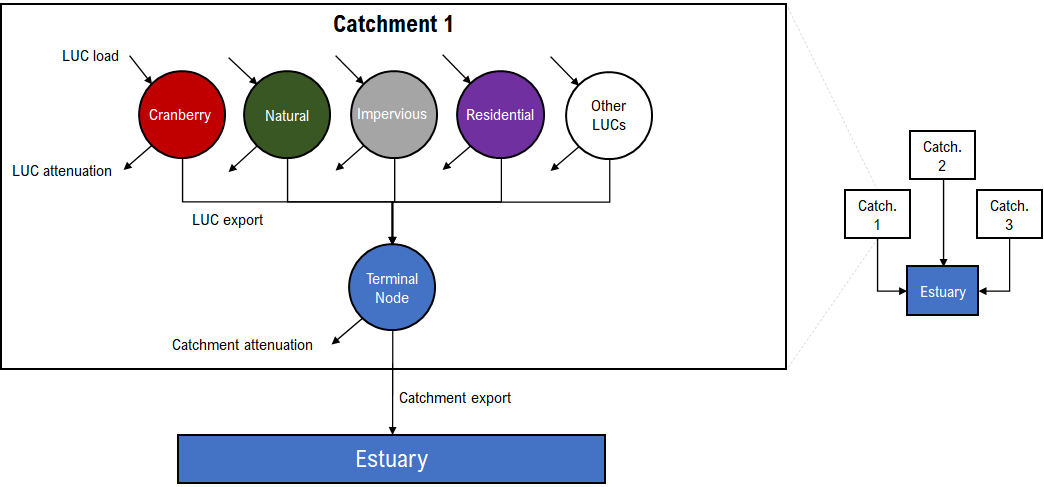

1. Since the assumption is that all land uses within a subwatershed represent a node draining to a single outlet, and all subwatersheds connect directly to the estuary
2. If the objective is to find/demonstrate which bogs intercept high nitrate waters how would the node based analysis contribute to that?


3. How do we determine what type of terminal node each subwatershed drains to?

Types of terminal nodes

>1. Stream/Estuary
>2. Wetland -> Stream/Estuary
>3. Pond -> Stream/Estuary
